<a href="https://colab.research.google.com/github/GustavBoye/DRED_Autoencoder/blob/main/Simulated_stock_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


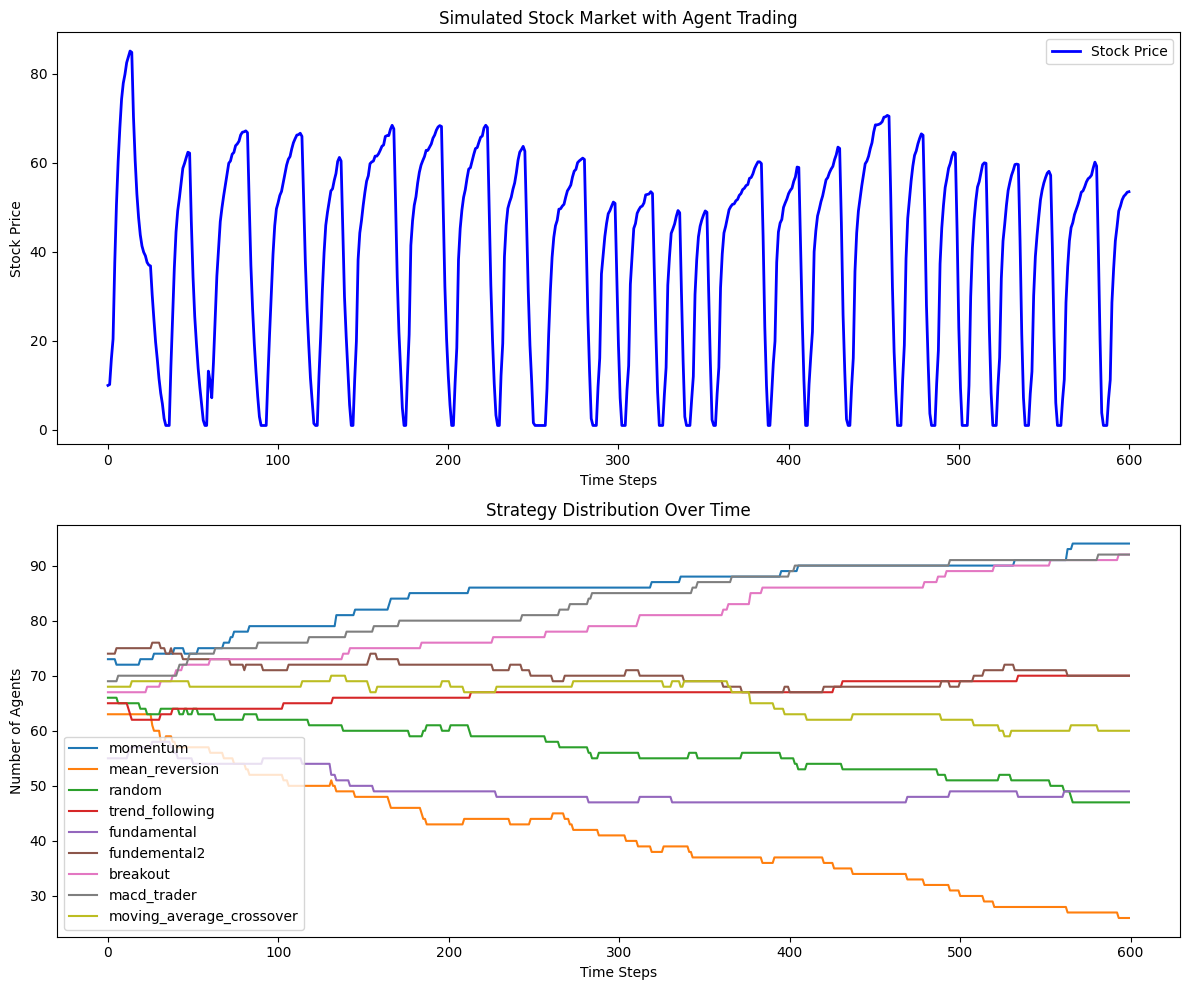

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Market settings
initial_price = 10
num_agents = 600
trading_rounds = 6000
initial_money = 100

# Define agent strategies
strategies = ["momentum", "mean_reversion", "random", "trend_following",
              "fundamental", "fundemental2", "breakout", "macd_trader", "moving_average_crossover"]

class TradingAgent:
    def __init__(self, strategy):
        self.money = initial_money
        self.strategy = strategy
        self.holdings = 0
        self.entry_price = None
        self.stop_loss_pref = random.uniform(0.05, 0.5)
        self.take_profit_pref = random.uniform(0.05, 0.5)
        self.timeframe = random.randint(1, 53)
        self.min_price = random.randint(1, 100)

    def reset_agent(self):
        self.money = initial_money
        self.strategy = random.choice(strategies)
        self.holdings = 0
        self.entry_price = None
        self.stop_loss_pref = random.uniform(0.05, 0.5)
        self.take_profit_pref = random.uniform(0.05, 0.5)
        self.timeframe = random.randint(1, 8)
        self.min_price = random.randint(1, 100)

    def decide_trade(self, price_history):
        if len(price_history) < 2:
            return random.choice([-1, 1])

        current_price = price_history[-1]

        if self.strategy == "momentum":
            return 1 if price_history[-1] > price_history[-2] else -1
        elif self.strategy == "mean_reversion":
            return 1 if price_history[-1] < np.mean(price_history[-10:]) else -1
        elif self.strategy == "random":
            return random.choice([-1, 1])
        elif self.strategy == "trend_following":
            return 1 if np.mean(price_history[-3:]) > np.mean(price_history[-6:-3]) else -1
        elif self.strategy in ["fundamental", "fundemental2"]:
            return 1 if price_history[-1] < self.min_price else -1
        elif self.strategy == "breakout":
            if len(price_history) > 2*self.timeframe:
                recent_high = max(price_history[-2*self.timeframe:])
                recent_low = min(price_history[-2*self.timeframe:])
                if current_price > recent_high:
                    return 1
                elif current_price < recent_low:
                    return -1
            return 0
        elif self.strategy == "macd_trader":
            if len(price_history) < 26:
                return 0
            short_ema = np.mean(price_history[-12:])
            long_ema = np.mean(price_history[-26:])
            macd = short_ema - long_ema
            signal = np.mean([macd] + price_history[-9:])
            return 1 if macd > signal else -1 if macd < signal else 0
        elif self.strategy == "moving_average_crossover":
            if len(price_history) < 20*self.timeframe:
                return 0
            short_ma = np.mean(price_history[-5*self.timeframe:])
            long_ma = np.mean(price_history[-20*self.timeframe:])
            return 1 if short_ma > long_ma else -1 if short_ma < long_ma else 0

        return 0

    def buy(self, price):
        if self.holdings == 0 and self.money >= price:
            self.entry_price = price
            self.money -= price * 0.1
            self.holdings = 1

    def sell(self, price):
        if self.holdings == 1:
            self.money += price * 0.1
            self.holdings = 0

    def run(self, price_history):
        if random.randint(0, 400) == 0 and self.money < 100:
            self.reset_agent()
        self.money += 0.001
        action = self.decide_trade(price_history)
        if action == 1:
            self.buy(price_history[-1])
        elif action == -1:
            self.sell(price_history[-1])
        elif self.holdings == 1:
            if price_history[-1] < self.entry_price * (1 - self.stop_loss_pref):
                self.sell(price_history[-1])
            elif price_history[-1] > self.entry_price * (1 + self.take_profit_pref):
                self.sell(price_history[-1])

# Initialize agents
agents = [TradingAgent(random.choice(strategies)) for _ in range(num_agents)]

# Simulating the stock market
stock_price = [initial_price]
strategy_counts = {strategy: [] for strategy in strategies}

for _ in range(trading_rounds):
    current_price = stock_price[-1]

    # Track strategy distribution
    current_strategy_count = {strategy: 0 for strategy in strategies}
    for agent in agents:
        current_strategy_count[agent.strategy] += 1

    for strategy in strategies:
        strategy_counts[strategy].append(current_strategy_count[strategy])

    # Track demand
    buy_pressure = sum(1 for agent in agents if agent.decide_trade(stock_price) == 1)
    sell_pressure = sum(1 for agent in agents if agent.decide_trade(stock_price) == -1)

    # Price movement based on demand-supply balance
    price_change = (buy_pressure - sell_pressure) * 0.1
    new_price = max(1, current_price + price_change)
    stock_price.append(new_price + random.uniform(0, 0.01))

    # Each agent trades based on the new price
    for agent in agents:
        agent.run(stock_price)

# Plot stock price evolution
plt.figure(figsize=(12, 10))

# First subplot: Stock price
plt.subplot(2, 1, 1)
plt.plot(stock_price, label="Stock Price", color="blue", linewidth=2)
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.title("Simulated Stock Market with Agent Trading")
plt.legend()

# Second subplot: Strategy usage over time
plt.subplot(2, 1, 2)
for strategy in strategies:
    plt.plot(strategy_counts[strategy], label=strategy)
plt.xlabel("Time Steps")
plt.ylabel("Number of Agents")
plt.title("Strategy Distribution Over Time")
plt.legend()

plt.tight_layout()
plt.show()
